In [18]:
import pandas as pd 
import pyarrow 
import os 
import sys 
import glob 
import numpy as np 
import matplotlib 
import matplotlib.pyplot as plt 
from scipy.fft import fft 
import datetime 
import sklearn 
import scipy 
import joblib 
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler 
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
import h2o 
from h2o.estimators import H2ODeepLearningEstimator
%matplotlib inline

In [24]:
df = pd.read_parquet('Day_2023-01-20_Rslt.parquet')

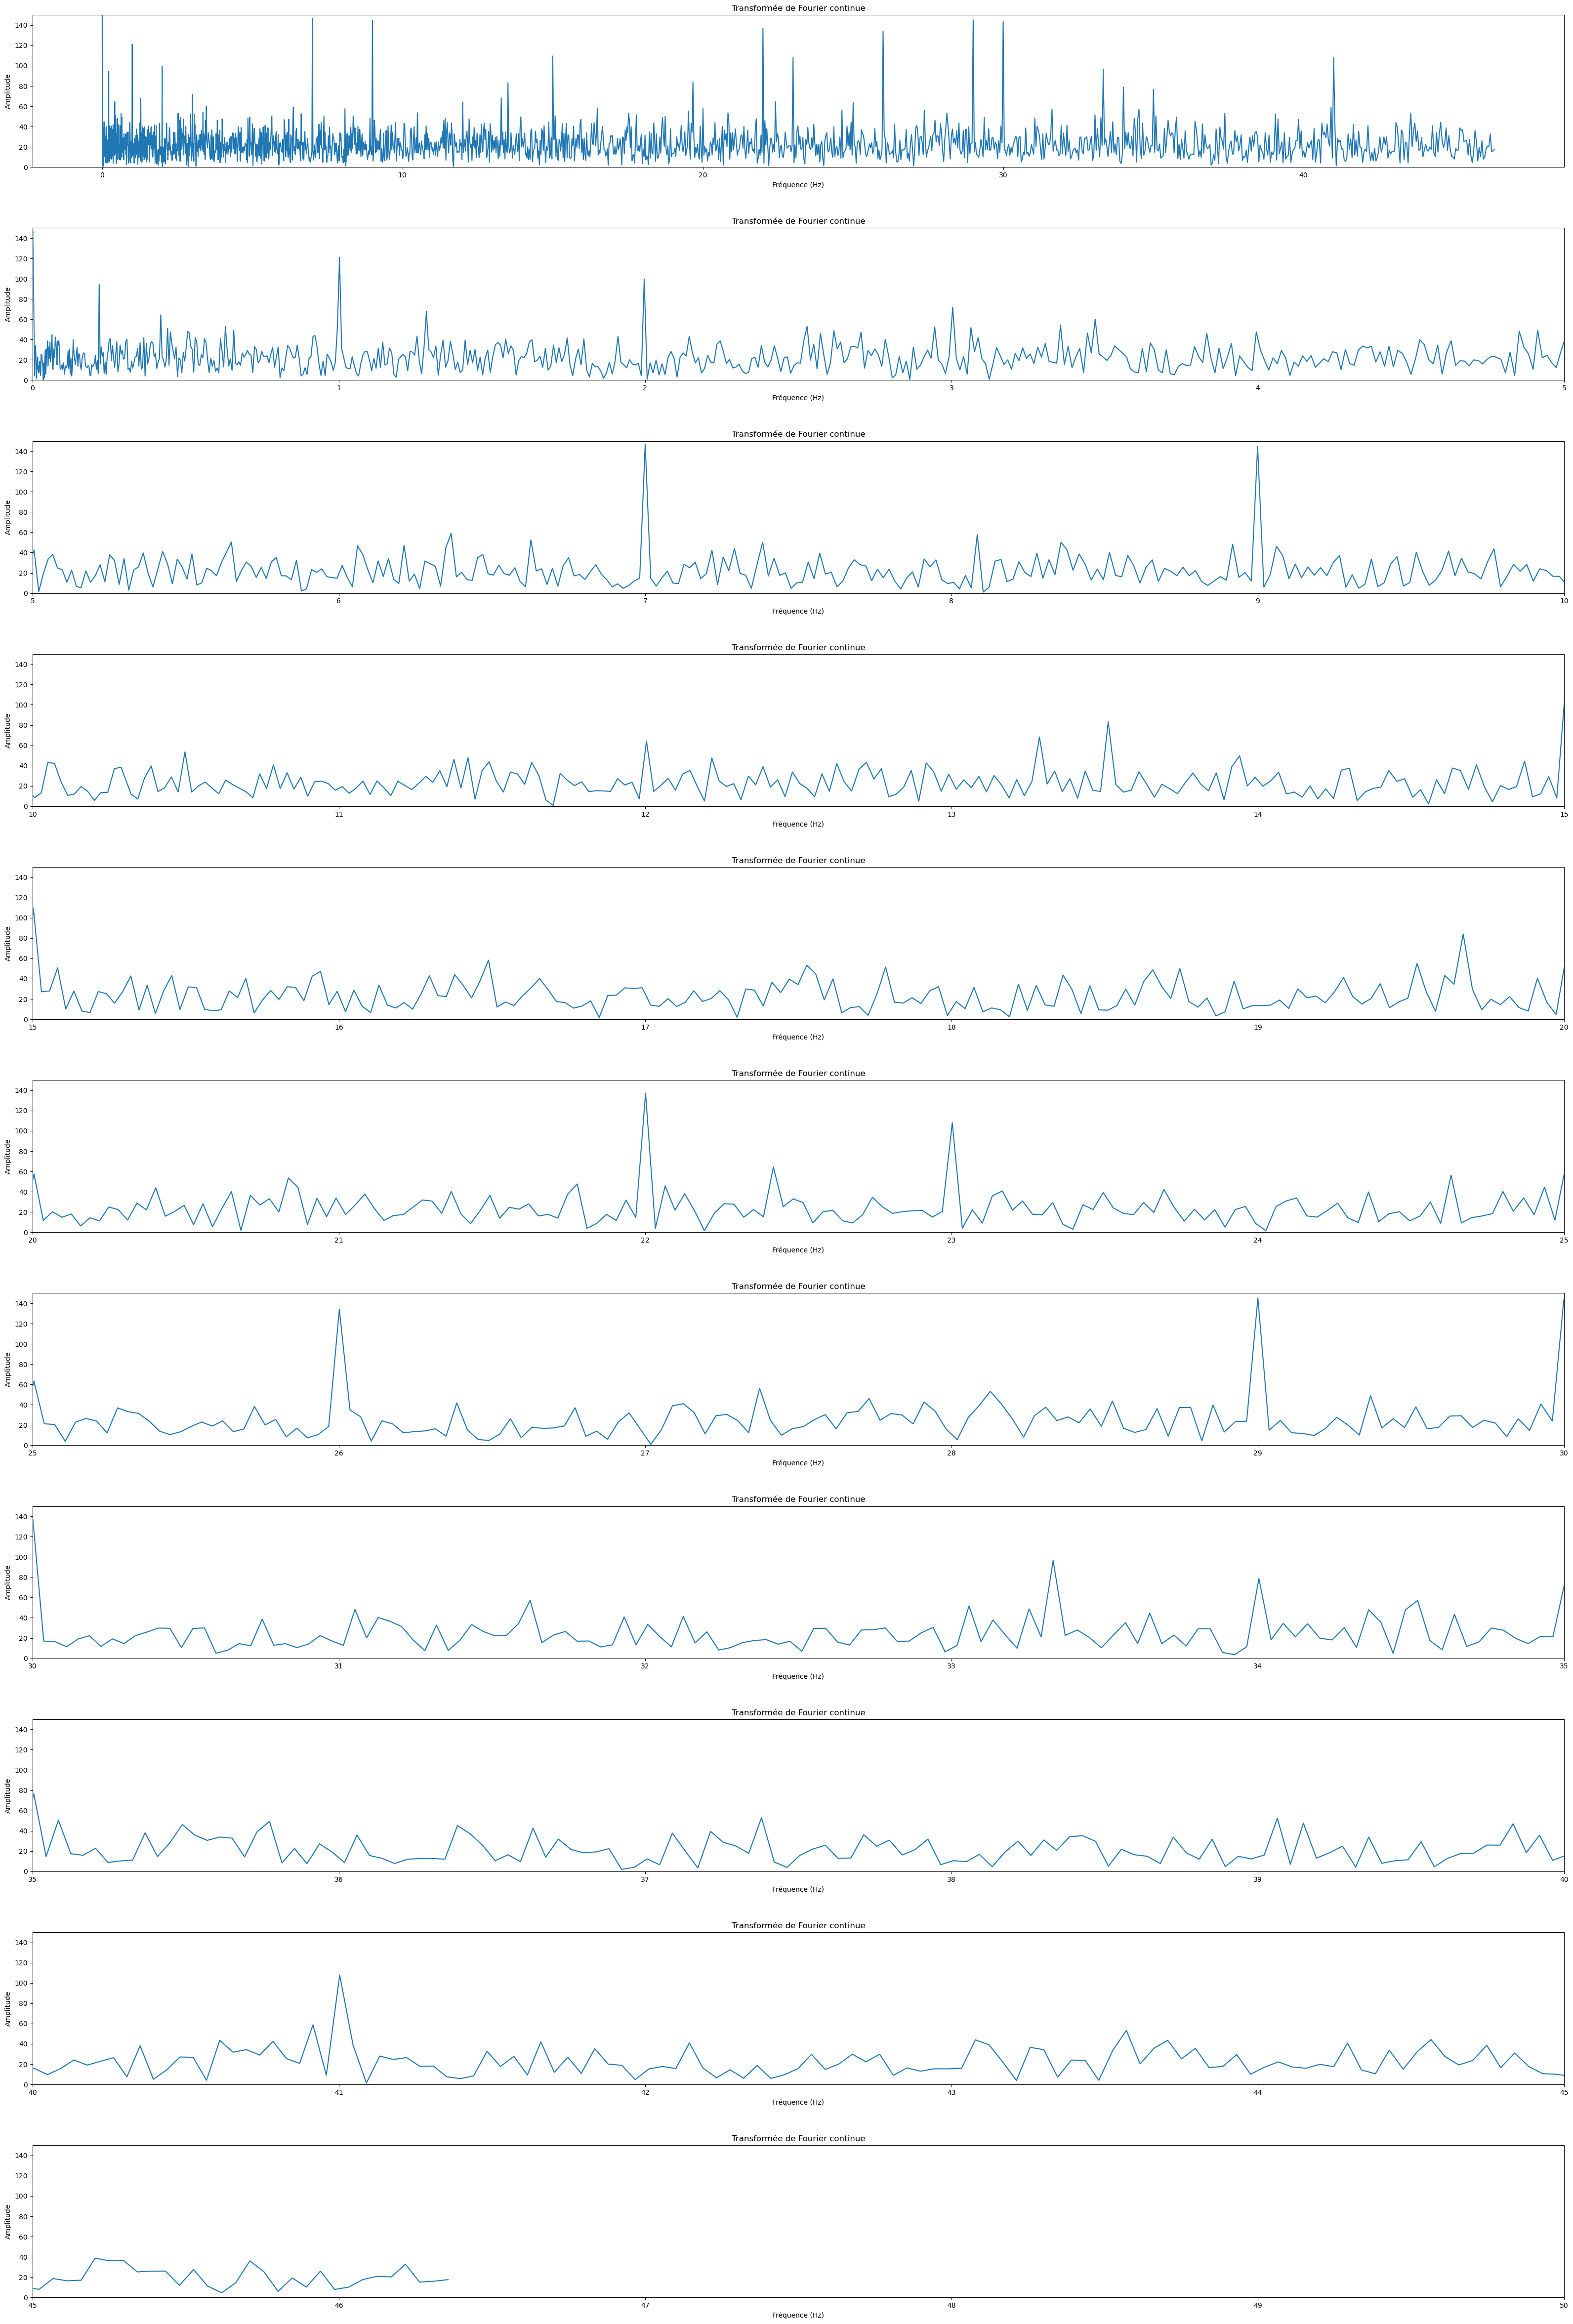

In [7]:
a=1
vibrations = df[df["sensor_id"]==a]["ax|mean"]
sampling_rate = (pd.to_datetime(df[df["sensor_id"]==a]['insertion_time_1s_Rounded']) - pd.to_datetime(df[df["sensor_id"]==a]['insertion_time_1s_Rounded'][0])).dt.total_seconds()
freq = np.fft.fftfreq(len(df[df["sensor_id"]==a]['insertion_time_1s_Rounded']), d=1/sampling_rate).iloc[0:2000]
fft_signal = np.zeros_like(freq, dtype=np.complex128)
for i, w in enumerate(2 * np.pi * freq):
    fft_signal[i] = np.trapz(vibrations * np.exp(-1j * w * sampling_rate), sampling_rate)

fig, axs = plt.subplots(11, 1, figsize=(40, 60), sharey=True)
axs[0].plot(freq, np.abs(fft_signal))
axs[0].set_xlabel('Fréquence (Hz)')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Transformée de Fourier continue')
for r in range (1,11):
    axs[r].plot(freq, np.abs(fft_signal))
    axs[r].set_xlabel('Fréquence (Hz)')
    axs[r].set_ylabel('Amplitude')
    axs[r].set_title('Transformée de Fourier continue')
    axs[r].set_xlim([r*5-5,r*5])
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.ylim([0,150])
plt.show()


In [8]:
def pca(train, test, variance=0.95):
    
    train = train.loc[:, train.apply(pd.Series.nunique) > 1]
    
    imputer = SimpleImputer(strategy='mean')
    train_imputed = pd.DataFrame(imputer.fit_transform(train))
    test_imputed = pd.DataFrame(imputer.transform(test.loc[:, train.columns]))

    preprocessParams = StandardScaler().fit(train_imputed)
    
    traintransformed = preprocessParams.transform(train_imputed)
    testtransformed = preprocessParams.transform(test_imputed)

    pca_model = PCA(n_components=train.shape[1])
    pca_model.fit(traintransformed)

    for i in range(train.shape[1]):
        if pca_model.explained_variance_ratio_[:i+1].sum() >= variance:
            break

    train_res = pd.DataFrame(train)
    train_res['T2stats'] = pca_model.score_samples(traintransformed)
    train_res['T2critical'] = pca_model.score(pca_model.transform(traintransformed))
    train_res['T2outlier'] = (train_res['T2stats'] > train_res['T2critical'])
    train_res['SPEstats'] = ((train_imputed - pca_model.inverse_transform(pca_model.transform(traintransformed))) ** 2).sum(axis=1)
    train_res['SPEcritical'] = train_res['SPEstats'].quantile(0.95)
    train_res['SPEoutlier'] = train_res['SPEstats'] > train_res['SPEcritical']

    test_res = pd.DataFrame(columns=train.columns)
    test_res['T2stats'] = pca_model.score_samples(testtransformed)
    test_res['T2critical'] = pca_model.score(pca_model.transform(testtransformed))
    test_res['T2outlier'] = (test_res['T2stats'] > test_res['T2critical'])
    test_res['SPEstats'] = ((test_imputed - pca_model.inverse_transform(pca_model.transform(testtransformed))) ** 2).sum(axis=1)
    test_res['SPEcritical'] = train_res['SPEcritical']
    test_res['SPEoutlier'] = test_res['SPEstats'] > test_res['SPEcritical']

    return pd.concat([train_res, test_res], axis=0, ignore_index=True)

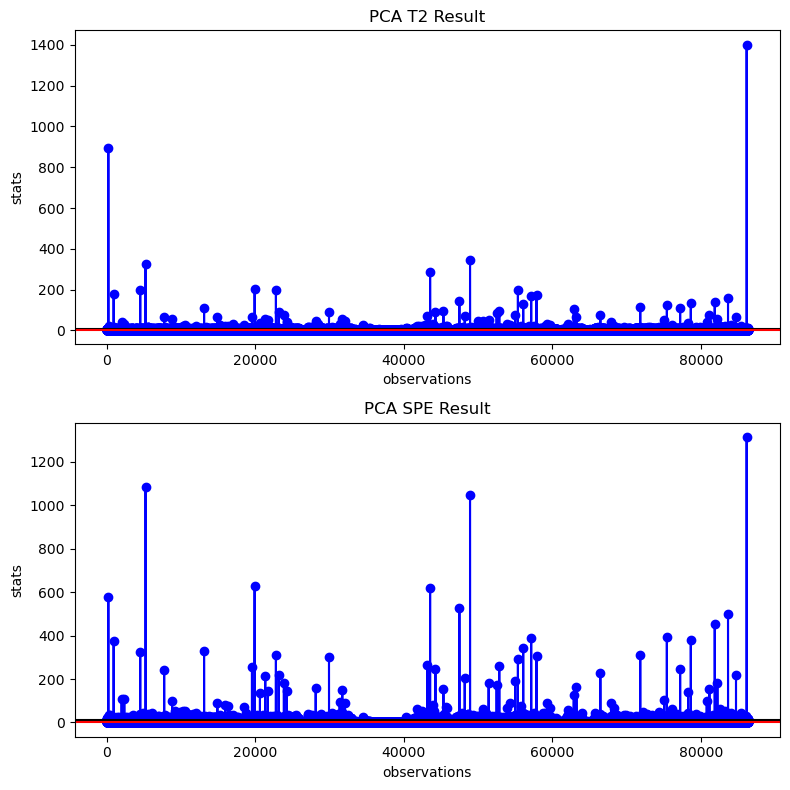

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
axes[0].plot(abs(pca_result['T2stats']), color='blue', marker='o')
axes[0].axhline(y=abs(pca_result['T2critical']).iloc[0], color='black')
axes[0].axhline(y=abs(pca_result['T2outlier']).iloc[0], color='red')
axes[0].set_title('PCA T2 Result')
axes[0].set_xlabel('observations')
axes[0].set_ylabel('stats')

axes[1].plot(pca_result['SPEstats'], color='blue', marker='o')
axes[1].axhline(y=pca_result['SPEcritical'].iloc[0], color='black')
axes[1].axhline(y=pca_result['SPEoutlier'].iloc[0], color='red')
axes[1].set_title('PCA SPE Result')
axes[1].set_xlabel('observations')
axes[1].set_ylabel('stats')

plt.tight_layout()
plt.show()

In [13]:
def machine_status(data, variance=0.95, t2_threshold=200, spe_threshold=2000):
    # preprocess the data to handle missing values
    imputer = SimpleImputer(strategy='mean')
    data_imputed = pd.DataFrame(imputer.fit_transform(data))

    # calculate the pre-process parameters from the dataset
    preprocessParams = StandardScaler().fit(data_imputed)
    # transform the dataset using the parameters
    transformed = preprocessParams.transform(data_imputed)

    # calibrate data for PCA
    pca_model = PCA(n_components=data.shape[1])
    pca_model.fit(transformed)

    # find the number of principal components that explain at least the specified variance
    for i in range(data.shape[1]):
        if pca_model.explained_variance_ratio_[:i+1].sum() >= variance:
            break

    # calculate T2 and SPE statistics for the dataset
    res = pd.DataFrame(data)
    res['T2stats'] = pca_model.score_samples(transformed)
    res['T2critical'] = pca_model.score(pca_model.transform(transformed))
    res['T2outlier'] = (res['T2stats'] > t2_threshold)
    res['SPEstats'] = ((data_imputed - pca_model.inverse_transform(pca_model.transform(transformed))) ** 2).sum(axis=1)
    res['SPEcritical'] = res['SPEstats'].quantile(0.95)
    res['SPEoutlier'] = res['SPEstats'] > spe_threshold

    # predict machine status based on T2 and SPE statistics
    res['status'] = np.where(res['T2outlier'] | res['SPEoutlier'], 0, 1)

    return res

In [29]:
ds=df[df["sensor_id"]==a][columns]
resu=machine_status(ds)
resu

,ax|mean,ay|mean,az|mean,T2stats,T2critical,T2outlier,SPEstats,SPEcritical,SPEoutlier,status
0,0.948336,-0.061791,0.010856,-6.178396,-5.262684,False,16.804415,11.856551,False,1
1,0.961130,-0.038417,-0.000266,-4.505467,-5.262684,False,4.882489,11.856551,False,1
2,0.957065,-0.055246,0.000639,-3.357126,-5.262684,False,2.300470,11.856551,False,1
3,0.956975,-0.050950,0.000989,-2.798928,-5.262684,False,1.359931,11.856551,False,1
4,0.953412,-0.044767,0.007882,-3.397759,-5.262684,False,5.219881,11.856551,False,1
...,...,...,...,...,...,...,...,...,...,...
86310,0.956874,-0.049214,-0.000340,-3.450941,-5.262684,False,1.906932,11.856551,False,1
86311,0.958453,-0.047379,0.001184,-2.552969,-5.262684,False,0.893702,11.856551,False,1
86312,0.945638,-0.050420,0.010366,-6.213968,-5.262684,False,16.279403,11.856551,False,1
86313,0.957739,-0.047776,0.004421,-2.511476,-5.262684,False,0.781472,11.856551,False,1


In [50]:
def kmeans_function(train, use_pca, variance):
    # Remove columns with zero variance
    train = train.loc[:, train.apply(lambda x: len(x.unique()) > 1)]

    if use_pca:
        # Calculate PCA
        scaler = StandardScaler()
        pca = PCA(n_components=train.shape[1])
        transformed = pca.fit_transform(scaler.fit_transform(train))

        kmeans = KMeans(n_clusters=2)
        cluster_labels = kmeans.fit_predict(transformed)
        
        # Compute the silhouette score
        silhouette = silhouette_score(transformed, cluster_labels)
    else:
        scaler = StandardScaler()
        transformed = scaler.fit_transform(train)

        kmeans = KMeans(n_clusters=2)
        cluster_labels = kmeans.fit_predict(transformed)
        
        # Compute the silhouette score
        silhouette = silhouette_score(transformed, cluster_labels)

    train['cluster'] = cluster_labels
    return train, silhouette

In [52]:
usePCA = True
variance = 0.95
kmeans_pca_res = kmeans_function(train, usePCA, variance)
kmeans_pca_res[0]

C:\Users\oussaman\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,ax|mean,ay|mean,az|mean,cluster
0,0.948336,-0.061791,0.010856,1
1,0.961130,-0.038417,-0.000266,0
2,0.957065,-0.055246,0.000639,0
3,0.956975,-0.050950,0.000989,0
4,0.953412,-0.044767,0.007882,1
...,...,...,...,...
69047,0.956821,-0.049735,0.002420,0
69048,0.955826,-0.047639,0.004852,0
69049,0.956489,-0.050382,0.005296,0
69050,0.956439,-0.049478,0.005477,0


In [53]:
usePCA = False
kmeans_res = kmeans_function(train, usePCA, variance)
kmeans_res[0]

C:\Users\oussaman\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,ax|mean,ay|mean,az|mean,cluster
0,0.948336,-0.061791,0.010856,1
1,0.961130,-0.038417,-0.000266,0
2,0.957065,-0.055246,0.000639,0
3,0.956975,-0.050950,0.000989,0
4,0.953412,-0.044767,0.007882,1
...,...,...,...,...
69047,0.956821,-0.049735,0.002420,0
69048,0.955826,-0.047639,0.004852,0
69049,0.956489,-0.050382,0.005296,0
69050,0.956439,-0.049478,0.005477,0


In [54]:
print("Silhouette score without pca:",kmeans_res[1])
print("Silhouette score with pca:",kmeans_pca_res[1])

Silhouette score without pca: 0.3706204270021757
Silhouette score with pca: 0.3706187603874162


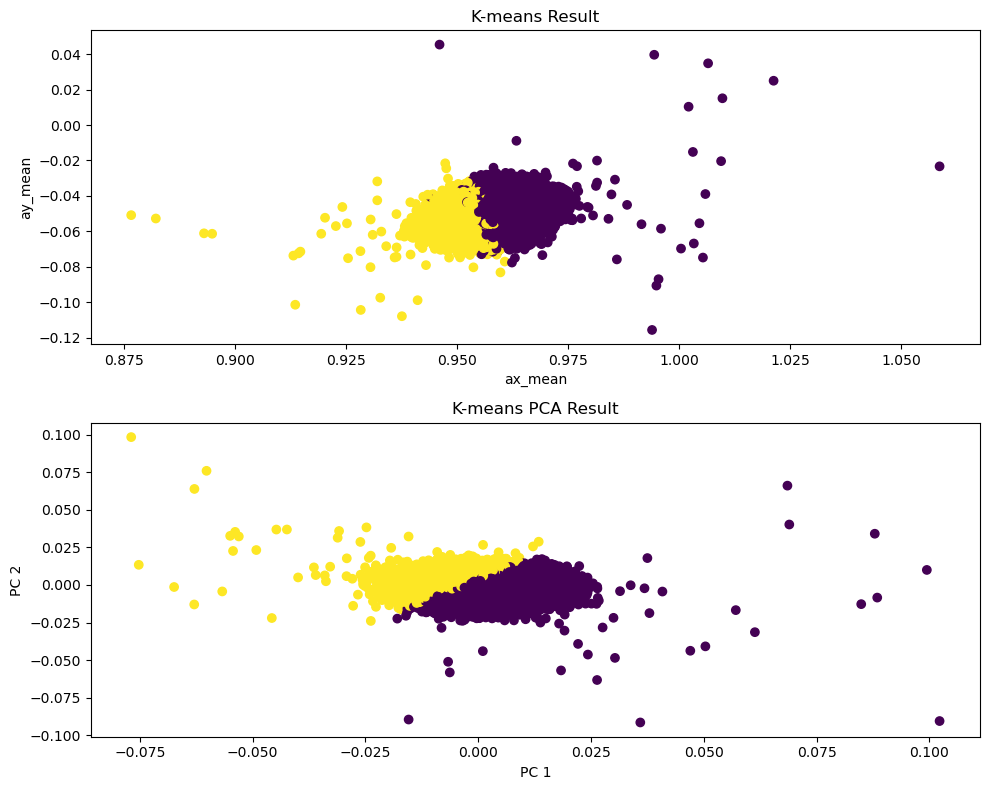

In [43]:
# PCA Model for visualization
pca_model = PCA(n_components=2)
pca_features = pca_model.fit_transform(train)

# Plot K-means Result
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.scatter(train['ax|mean'], train['ay|mean'], c=kmeans_res[0]['cluster'])
plt.title('K-means Result')
plt.xlabel('ax_mean')
plt.ylabel('ay_mean')

# Plot K-means PCA Result
plt.subplot(2, 1, 2)
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=kmeans_pca_res[0]['cluster'])
plt.title('K-means PCA Result')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.tight_layout()
plt.show()

In [49]:
def predict_machine_status(new_data, kmeans_result):
    cluster_counts = kmeans_result['cluster'].value_counts()
    most_common_cluster = cluster_counts.idxmax()
    
    # Predict the status based on the cluster of the new data
    new_data_cluster = kmeans_result.loc[kmeans_result.index[-1], 'cluster']  # Get the cluster of the new data
    
    if new_data_cluster == most_common_cluster:
        return "Machine is not down"
    else:
        return "Machine is down"

# Anomaly detection with PCA
usePCA = True
variance = 0.95

kmeans_pca_res = kmeans_function(train, usePCA, variance)


# Predict machine status for new_data
predict_machine_status(ds, kmeans_pca_res[0])

C:\Users\oussaman\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'Machine is not down'

In [16]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.17+10-LTS-269, mixed mode)
  Starting server from C:\Users\poste\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\poste\AppData\Local\Temp\tmpqxf2kdn8
  JVM stdout: C:\Users\poste\AppData\Local\Temp\tmpqxf2kdn8\h2o_poste_started_from_python.out
  JVM stderr: C:\Users\poste\AppData\Local\Temp\tmpqxf2kdn8\h2o_poste_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,09 secs
H2O_cluster_timezone:,Africa/Casablanca
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_poste_2d7frc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.971 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


In [17]:
train_h2o = h2o.H2OFrame(train)
test_h2o = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [19]:
# Define the layers in the autoencoder
hidden_layers = [50, 10, 50]

# Initialize the autoencoder model
model_unsup = H2ODeepLearningEstimator(
    activation="Tanh",
    autoencoder=True,
    ignore_const_cols=False,
    reproducible=True,
    seed=42,
    hidden=hidden_layers,
    epochs=100,
    model_id="Test01"
)

# Train the model on the training data
model_unsup.train(x=list(range(2, train_h2o.ncol)), training_frame=train_h2o)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: Test01


Status of Neuron Layers: auto-encoder, gaussian distribution, Quadratic loss, 1.211 weights/biases, 19,2 KB, 1.309.309 training samples, mini-batch size 1
    layer    units    type    dropout    l1    l2    mean_rate            rate_rms               momentum    mean_weight            weight_rms           mean_bias               bias_rms
--  -------  -------  ------  ---------  ----  ----  -------------------  ---------------------  ----------  ---------------------  -------------------  ----------------------  -----------------------
    1        1        Input   0.0
    2        50       Tanh    0.0        0.0   0.0   1.0007865583896638   0.0031278152018785477  0.0         -0.13117168106138707   0.4570133686065674   -0.0022178974672481216  0.007660765200853348
    3        10       Tanh    0.0        0.0   0.0   1.0028707292079926   0.0015370328910648823  0.0         0.005592349417129299   0.1921284794807434   -0.0010423691631371874  0.009022779762744904
    4        50       Tanh    0.0        0.0   0.0   0.9981570868492127   0.0038658054545521736  0.0         0.013565995745360852   0.18571102619171143  0.0026688155811380627   0.007573993876576424
    5        1        Tanh               0.0   0.0   0.20770833283662796  0.07482361793518066    0.0         -0.005422528246417642  0.01573977619409561  -0.0046280648801515206  1.0971281125650402e-154

ModelMetricsAutoEncoder: deeplearning
** Reported on train data. **

MSE: 2.5202014616604593e-06
RMSE: 0.0015875142398291927

Scoring History: 
     timestamp            duration          training_speed    epochs    iterations    samples    training_rmse          training_mse
---  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------------  ----------------------
     2023-09-03 19:29:02  0.616 sec         0,00000 obs/sec   0.0       0             0.0        0.028249462021598178   0.0007980321045097179
     2023-09-03 19:29:07  4.896 sec         16260 obs/sec     1.0       1             68911.0    0.01215639209145993    0.00014777786868130953
     2023-09-03 19:29:11  8.875 sec         16854 obs/sec     2.0       2             137822.0   0.002777289872998938   7.713339038662458e-06
     2023-09-03 19:29:15  12.948 sec        16943 obs/sec     3.0       3             206733.0   0.006569317195086332   4.3155928409656956e-05
     2023-09-03 19:29:19  17.016 sec        16994 obs/sec     4.0       4             275644.0   0.0060233683068175005  3.628096575957352e-05
     2023-09-03 19:29:23  20.966 sec        17114 obs/sec     5.0       5             344555.0   0.004097797341815634   1.679194305459128e-05
     2023-09-03 19:29:27  24.930 sec        17186 obs/sec     6.0       6             413466.0   0.0017996122314035748  3.2386041834173537e-06
     2023-09-03 19:29:31  29.087 sec        17121 obs/sec     7.0       7             482377.0   0.002848161081257169   8.112021544788007e-06
     2023-09-03 19:29:35  33.147 sec        17124 obs/sec     8.0       8             551288.0   0.001735560970808329   3.01217188339315e-06
     2023-09-03 19:29:39  37.099 sec        17177 obs/sec     9.0       9             620199.0   0.0027268972981016066  7.4359688743938415e-06
---  ---                  ---               ---               ---       ---           ---        ---                    ---
     2023-09-03 19:29:47  45.645 sec        17010 obs/sec     11.0      11            758021.0   0.0022573047317732985  5.095424652086123e-06
     2023-09-03 19:29:51  49.617 sec        17052 obs/sec     12.0      12            826932.0   0.0016004045163149835  2.5612946158413964e-06
     2023-09-03 19:29:55  53.568 sec        17094 obs/sec     13.0      13            895843.0   0.0015875142398291927  2.5202014616604593e-06
     2023-09-03 19:29:59  57.581 sec        17113 obs/sec     14.0      14            964754.0   0.0015879937703992511  2.52172421482683e-06
   

In [31]:
# Calculate the anomaly score using the H2O Deep Learning model
anomaly_score = model_unsup.anomaly(train_h2o)

# Convert the anomaly score to a Pandas DataFrame
anomaly_score_df = anomaly_score.as_data_frame()

# Create a label for healthy data (0)
anomaly_score_df['y'] = 0

# View the top data
print(anomaly_score_df.head())

   Reconstruction.MSE  y
0        2.399458e-08  0
1        2.691158e-08  0
2        2.021513e-08  0
3        2.636032e-08  0
4        6.448765e-09  0


In [77]:
threshold = 0.15

# Calculate the anomaly scores for test data using the H2O Deep Learning model
test_anomaly_score = model_unsup.anomaly(test_h2o)

# Convert the anomaly scores to a Pandas DataFrame
test_anomaly_score_df = test_anomaly_score.as_data_frame()

# Create a label for healthy data (1)
test_anomaly_score_df['y'] = 1

# View the top data
print(test_anomaly_score_df.head())

   Reconstruction.MSE  y
0        2.259258e-08  1
1        3.856808e-08  1
2        1.780920e-08  1
3        1.493070e-08  1
4        2.146866e-08  1


In [81]:
# Combine the anomaly scores for train and test datasets
combined_results = pd.concat([anomaly_score_df, test_anomaly_score_df], axis=0)

# Reset the index of combined_results
combined_results = combined_results.reset_index(drop=True)

# Create a DataFrame with the threshold value
threshold_df = pd.DataFrame({'Threshold': [threshold] * len(combined_results)})

# Concatenate the combined results and threshold DataFrame horizontally
results = pd.concat([combined_results, threshold_df], axis=1)

# View the top data
print(results.head())


   Reconstruction.MSE  y  Threshold
0        2.399458e-08  0       0.15
1        2.691158e-08  0       0.15
2        2.021513e-08  0       0.15
3        2.636032e-08  0       0.15
4        6.448765e-09  0       0.15


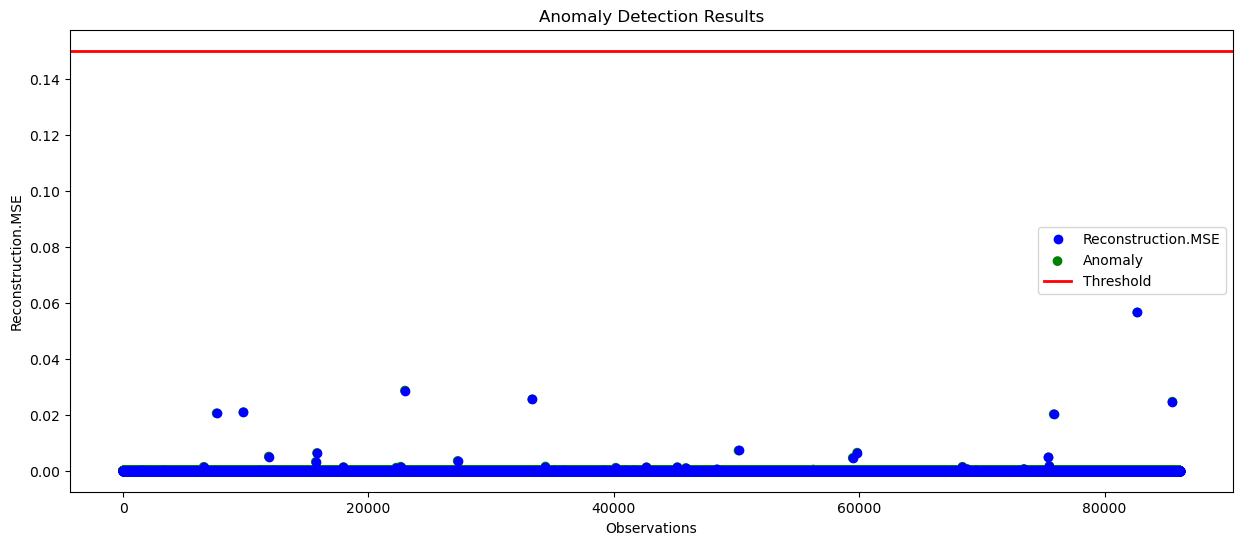

In [82]:
# Adjust plot sizes
plt.figure(figsize=(15, 6))

# Create the plot
plt.plot(results['Reconstruction.MSE'], marker='o', linestyle='none', label='Reconstruction.MSE', color='blue')
plt.xlabel('Observations')
plt.ylabel('Reconstruction.MSE')
plt.title('Anomaly Detection Results')

# Highlight anomalies using green and red points
threshold = results['Threshold'].iloc[0]  # Assuming the threshold is the same for all rows
colors = ['green' if mse < threshold else 'red' for mse in results['Reconstruction.MSE']]
plt.scatter(range(len(results)), results['Reconstruction.MSE'], c=colors, marker='o', label='Anomaly')

# Add a horizontal line for the threshold
plt.axhline(y=threshold, color='red', linestyle='-', linewidth=2, label='Threshold')

# Show legend
plt.legend()

# Show the plot
plt.show()

In [83]:
def detect_anomalies_with_autoencoder(df, threshold):
# Convert the DataFrame to an H2O frame
    df_h2o = h2o.H2OFrame(df)

    # Generate anomaly scores for the DataFrame using the autoencoder model
    anomaly_scores = model_unsup.anomaly(df_h2o)

    # Convert the H2O frame to a Pandas DataFrame
    anomaly_scores_df = anomaly_scores.as_data_frame()

    # Identify anomalies based on the threshold
    anomaly_scores_df['Anomaly'] = (anomaly_scores_df['Reconstruction.MSE'] > threshold).astype(int)

    return anomaly_scores_df

# Assuming you have 'your_dataframe' and 'model_unsup' (trained autoencoder model) defined
# Use the detect_anomalies_with_autoencoder function
detected_anomalies = detect_anomalies_with_autoencoder(ds, threshold)

# Print or analyze the detected anomalies
detected_anomalies

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


,Reconstruction.MSE,Anomaly
0,2.399458e-08,0
1,2.691158e-08,0
2,2.021513e-08,0
3,2.636032e-08,0
4,6.448765e-09,0
...,...,...
86134,4.058405e-08,0
86135,1.976430e-08,0
86136,2.713183e-08,0
86137,4.333120e-08,0


In [84]:
detected_anomalies[detected_anomalies['Anomaly']==1]

,Reconstruction.MSE,Anomaly
